In [9]:
%load_ext autoreload
%autoreload 2
#%matplotlib matplotlib
import cmcrameri.cm as cmc  # Importing the cmcrameri colormaps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%run figures.py 'little_dev_model/chem_model.h5' 

In [11]:
def sum_variables(xarray_obj, var_names, new_var_name):
    """
    Sums specified variables in an xarray object element-wise and adds the result as a new variable.
    
    Parameters:
    xarray_obj (xr.Dataset): The xarray Dataset containing the variables.
    var_names (list of str): A list of variable names to sum.
    new_var_name (str): The name of the new variable to store the sum.
    
    Returns:
    xr.Dataset: The modified xarray Dataset with the new summed variable.
    """
    # Check if all variable names exist in the xarray object
    missing_vars = [var for var in var_names if var not in xarray_obj.data_vars]
    if missing_vars:
        raise ValueError(f"The following variables are not in the xarray object: {missing_vars}")
    
    # Initialize a zero-filled DataArray based on the first variable's shape and coordinates
    sum_var = xr.zeros_like(xarray_obj[var_names[0]])
    
    # Sum the variables element-wise
    for var_name in var_names:
        sum_var += xarray_obj[var_name]
    
    # Add the summed variable to the xarray object
    xarray_obj[new_var_name] = sum_var
    
    return xarray_obj



In [12]:
primary_minerals = ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
secondary_minerals = ['Tremolite', 'Chrysotile', 'Talc', 'Quartz', 'Saponite-Mg', 'Illite_Mg', 
                      'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 
                      'Anhydrite', 'Calcite']

clays = ['Saponite-Mg', 'Illite_Mg', 'Chamosite-7A', 'Clinochlore-7A']
zeolites = ['Analcime']
amphiboles = ['Tremolite']
serpentinites = ['Chrysotile', 'Talc']
epidotes = ['Epidote', 'Zoisite']
olivine = ['Forsterite', 'Fayalite']
clinopyroxenes = ['Diopside', 'Hedenbergite']
plagioclases = ['Anorthite', 'Albite']
sulfates = ['Anhydrite']
carbonates = ['Calcite']

secondary_mineral_groups = {
    'clays': clays,
    'zeolites': zeolites,
    'amphiboles': amphiboles,
    'serpentinites': serpentinites,
    'epidotes': epidotes,
    'sulfates': sulfates,
    'carbonates': carbonates:
}

primary_mineral_groups = {
    'olivine': olivine,
    'clinopyroxenes': clinopyroxenes,
    'plagioclases': plagioclases
}

for group, minerals in primary_mineral_groups.items():
    minerals = [string + "_VF" for string in minerals]
    data = sum_variables(data, minerals, group + "_VF")

for group, minerals in secondary_mineral_groups.items():
    minerals = [string + "_VF" for string in minerals]
    data = sum_variables(data, minerals, group + "_VF")


primary_minerals_VF = [string + "_VF" for string in primary_minerals]
secondary_minerals_VF = [string + "_VF" for string in secondary_minerals]

data = sum_variables(data, primary_minerals_VF, 'primary_minerals_VF')
data = sum_variables(data, secondary_minerals_VF, 'secondary_minerals_VF')
data['percentage_alteration'] = data['secondary_minerals_VF'] / data['primary_minerals_VF'].isel(time=0) * 100

{'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
{'clays': ['Saponite-Mg', 'Illite_Mg', 'Chamosite-7A', 'Clinochlore-7A'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'serpentinites': ['Chrysotile', 'Talc'], 'epidotes': ['Epidote', 'Zoisite']}


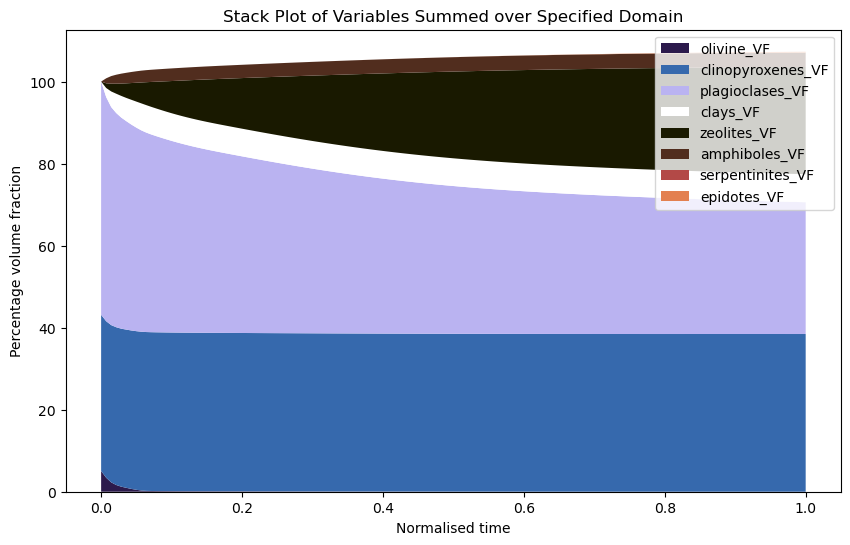

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import cmcrameri.cm as cm

# Select a sequential colormap from cmcrameri
# Define the number of groups (or layers) in the stack plot
# Extract colors from the colormap
colors_cool = cm.devon(np.linspace(0, 1, 4))  # Adjust 'num_groups' to the number of layers
colors_hot = cm.lajolla(np.linspace(0, 1, 6))
colors = np.vstack((colors_cool, colors_hot))
# Create a custom color cycler using the extracted colors
custom_cycler = cycler(color=colors)

def stack_plot(ax, ds, variable_groups, custom_cycler):
    variables = []
    for variable_group in variable_groups: 
        print(variable_group)
        for minerals in variable_group.keys():
            variables.extend([minerals + "_VF"])

    # Condition to sum over a part of the domain, based on another variable 'condition_var'
    # For example, let's sum where 'condition_var' is greater than a threshold value

    ax.set_prop_cycle(custom_cycler)
    
    threshold = 35
    condition = ds['percentage_alteration'].isel(time=-1) > threshold

    normalised = condition.sum(dim=['x', 'z', 'y']) * 0.9585
    # Calculate the sum of each variable over the specified condition
    sums = {}
    for var in variables:
        sums[var] = ds[var].where(condition).sum(dim=['x', 'z', 'y']) / normalised * 100 # Assuming 'x' and 'y' are spatial dimensions

    # Convert the sums into a stack plot
    # Assuming 'time' is the dimension you want to plot over
    stack_data = np.vstack([sums[var].values for var in variables])
    ax.stackplot(ds['time']/7000, stack_data, labels=variables)

    return ax


ds = data
# List of variables to include in the stack plot

fig, ax = plt.subplots(figsize=(10, 6))

stack_plot(ax, ds, [primary_mineral_groups, secondary_mineral_groups], custom_cycler)

# Create the stack plot
ax.set_xlabel('Normalised time')
ax.set_ylabel('Percentage volume fraction')
ax.legend()
plt.title('Stack Plot of Variables Summed over Specified Domain')
plt.show()


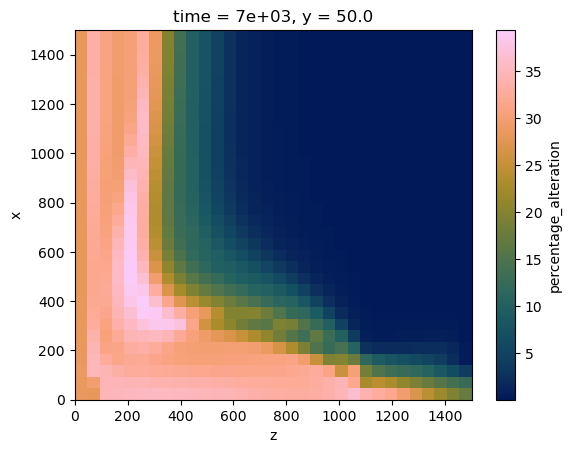

In [14]:
ds['percentage_alteration'].isel(time=-1).plot(cmap=cmc.batlow)

In [12]:
data['Porosity'].sel(time=7000).isel(x=0, z=0)

<xarray.DataArray 'Porosity' (y: 1)>
array([0.03268372])
Coordinates:
    time     float64 7e+03
    x        float64 5.859
  * y        (y) float64 50.0
    z        float64 5.859
Attributes:
    units:    None